In [1]:
import random
import string
import re
import nltk
import torch

import copy as cp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as opt
import torch.utils.data as dt

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV

from nlp_project.notebook_utils import evaluate, split
from nlp_project.nn_utils import init_gpu
from nlp_project.nn_classifier import Data, Classifier
from nlp_project.nn_extra import EarlyStopping, AdaptLR

In [2]:
seed = 69420
np.random.seed(seed)
random.seed(seed)

In [3]:
# Classification labels
labels = ["generated", "human"]

# English stopwords
nltk.download("stopwords")
eng_stopwords = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to /home/riga/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Import main dataset
df = pd.read_csv("../../AUTEXTIFICATION/subtask_1/train.tsv", sep="\t")
df = df.drop("id", axis=1)

df

,text,label
0,you need to stop the engine and wait until it ...,generated
1,The Commission shall publish the report; an in...,generated
2,"I have not been tweeting a lot lately, but I d...",generated
3,I pass my exam and really thankgod for that bu...,human
4,The template will have 3 parts: a mustache sha...,human
...,...,...
33840,"@PierreJoye i have a server already, thanks fo...",human
33841,10. Article 13 of Council Directive 80/777/EEC...,human
33842,"Crying because I have to cry for you?. No. No,...",generated
33843,"However, it will continue to offer customers a...",generated


In [5]:
def preprocess(df, field, remove_stop=True, vectorizer=None):
    # Convert all text to lowercase
    df[field] = df[field].apply(lambda x: x.lower())

    # Remove punctuation and reset multiple spaces to one
    punct_regex = re.compile("[" + string.punctuation + "\’'" + "]")
    whitespace_regex = re.compile(" ( )+")
    df[field] = df[field].apply(
        lambda x: whitespace_regex.sub(" ", punct_regex.sub(" ", x))
    )

    # Create dataframe without stopwords
    if remove_stop:
        df = df.copy()
        df[field] = df[field].apply(
            lambda x: " ".join([w for w in x.split() if w not in eng_stopwords])
        )
        
    x, y = df[field], df["label"]
    
    # Vectorize
    if vectorizer:
        x = vectorizer.fit_transform(x)
    
    return df, x, y

In [6]:
# min_df higher than 1 seems to perform worse
vectorizer = CountVectorizer()
# vectorizer = TfidfVectorizer()

In [7]:
df, x, y = preprocess(df, "text", vectorizer=vectorizer)

In [8]:
# train, test = train_test_split(df, test_size=0.2)
x_train, x_val, x_test, y_train, y_val, y_test = split(x, y, test_size=0.2, val_size=0.0)

In [9]:
# Vocabulary information of main dataset
vocab = " ".join(df["text"]).split(sep=" ")

vocab_count = nltk.Counter(vocab)
vocab_count.most_common(10)

[('shall', 16191),
 ('article', 14347),
 ('regulation', 13055),
 ('1', 9998),
 ('2', 9340),
 ('member', 6219),
 ('states', 5610),
 ('may', 5297),
 ('3', 5000),
 ('done', 4485)]

In [10]:
models = []

# Naive Bayes
nb = MultinomialNB()
nb_param = {"alpha":[0.001, 0.01, 0.1, 1, 10, 100]}
nb_clf = GridSearchCV(nb, nb_param, cv=5, scoring="f1_micro", verbose=1)
models.append({"name": "Naive Bayes", "model": nb_clf})

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr_param = [{
    "solver": ["liblinear"], 
    "penalty": ["l1", "l2"],
    "C":[0.01, 0.1, 1, 10]
},{
    "solver": ("lbfgs", "sag", "saga"), 
    "penalty": ["l2"],
    "C":[0.01, 0.1, 1]
}]
lr_clf = GridSearchCV(lr, lr_param, cv=5, scoring="f1_micro", verbose=1)
models.append({"name": "Linear Regression", "model": lr_clf})

# SVC
svc = SVC()
svc_param = {"kernel": ["rbf"], "C": [0.1, 1, 10]}
svc_clf = GridSearchCV(svc, svc_param, cv=5, scoring="f1_micro", verbose=1)
models.append({"name": "SVC", "model": svc_clf, "subsample": 0.7})

# Decision Tree
dtree = DecisionTreeClassifier()
dtree_param = {
    "criterion": ["gini", "entropy"], 
    # "min_samples_split": [2, 4, 8],
    # "min_samples_leaf": [1, 2, 4],
    "max_features": [None, "sqrt", "log2"],
}
dtree_clf =  GridSearchCV(dtree, dtree_param, cv=5, scoring="f1_micro", verbose=1)
models.append({"name": "Decision Tree", "model": dtree_clf})

# Random Forest
rf = RandomForestClassifier()
rf_param = {
    # "n_estimators": [50, 100, 200, 400],
    # "max_depth": [None, 5, 10],
    "criterion": ["gini", "entropy"],
    # "min_samples_split": [2, 4, 8],
    # "min_samples_leaf": [1, 2, 4],
    # "max_features": [None, "sqrt", "log2"],
    # "oob_score": [True, False]
}
rf_clf =  GridSearchCV(rf, rf_param, cv=5, scoring="f1_micro", verbose=1)
models.append({"name": "Random Forest", "model": rf_clf})

# Extra Trees
et = ExtraTreesClassifier()
et_param = {
    # "n_estimators": [50, 100, 200, 400],
    # "max_depth": [None, 5, 10],
    "criterion": ["gini", "entropy"],
    # "min_samples_split": [2, 4, 8],
    # "min_samples_leaf": [1, 2, 4],
    # "max_features": [None, "sqrt", "log2"],
    # "oob_score": [True, False]
}
et_clf =  GridSearchCV(et, et_param, cv=5, scoring="f1_micro", verbose=1)
models.append({"name": "Extra Trees", "model": et_clf})

In [11]:
for model in models:
    print(f"Training {model['name']}")
    
    x_train_, y_train_ = x_train, y_train
    if "subsample" in model.keys():
        x_train_, _, y_train_, _ = train_test_split(
            x_train, 
            y_train, 
            test_size=model["subsample"], 
            stratify=y_train
        )
        
    model["model"].fit(x_train_, y_train_)
    
    print("Found best model")
    model["best"] = model["model"].best_estimator_
    model["best"].fit(x_train, y_train)
    print("Trained best model")

Training Naive Bayes
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Found best model
Trained best model
Training Linear Regression
Fitting 5 folds for each of 17 candidates, totalling 85 fits
Found best model
Trained best model
Training SVC
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Found best model
Trained best model
Training Decision Tree
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Found best model
Trained best model
Training Random Forest
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Found best model
Trained best model
Training Extra Trees
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Found best model
Trained best model


Naive Bayes
Best parameters: {'alpha': 10}
Best CV score: 0.6992542052480186
              precision    recall  f1-score   support

   generated       0.66      0.79      0.72      3360
       human       0.74      0.59      0.66      3409

    accuracy                           0.69      6769
   macro avg       0.70      0.69      0.69      6769
weighted avg       0.70      0.69      0.69      6769



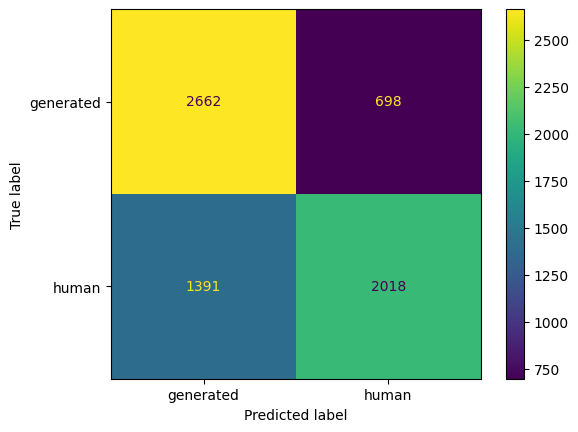

Linear Regression
Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}
Best CV score: 0.7461960662364923
              precision    recall  f1-score   support

   generated       0.74      0.76      0.75      3360
       human       0.76      0.74      0.75      3409

    accuracy                           0.75      6769
   macro avg       0.75      0.75      0.75      6769
weighted avg       0.75      0.75      0.75      6769



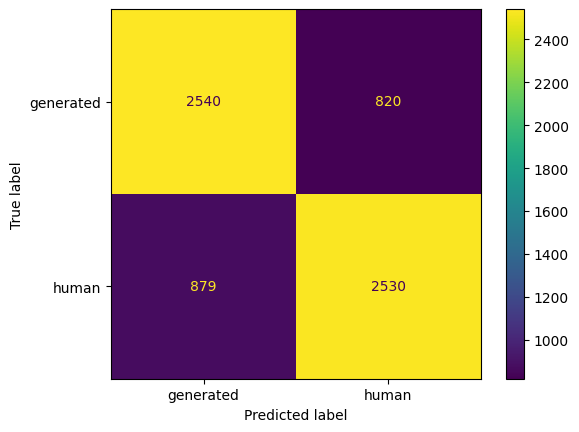

SVC
Best parameters: {'C': 1, 'kernel': 'rbf'}
Best CV score: 0.7281484653277757
              precision    recall  f1-score   support

   generated       0.75      0.76      0.75      3360
       human       0.76      0.74      0.75      3409

    accuracy                           0.75      6769
   macro avg       0.75      0.75      0.75      6769
weighted avg       0.75      0.75      0.75      6769



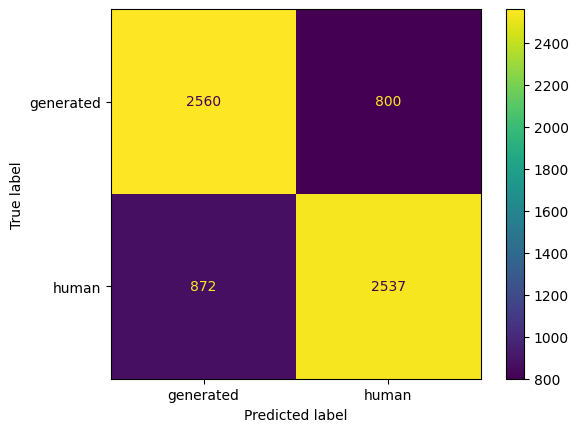

Decision Tree
Best parameters: {'criterion': 'entropy', 'max_features': None}
Best CV score: 0.6909070965137325
              precision    recall  f1-score   support

   generated       0.68      0.69      0.69      3360
       human       0.69      0.68      0.69      3409

    accuracy                           0.69      6769
   macro avg       0.69      0.69      0.69      6769
weighted avg       0.69      0.69      0.69      6769



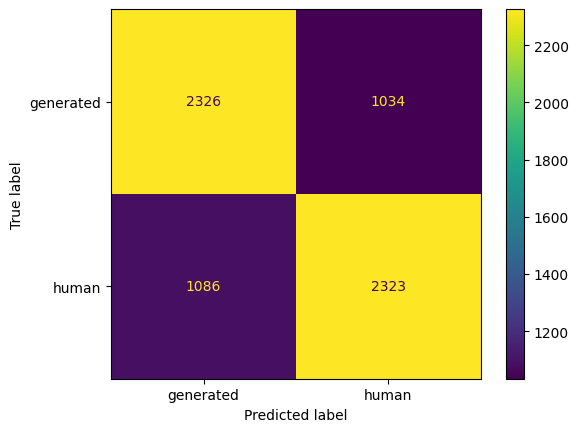

Random Forest
Best parameters: {'criterion': 'gini'}
Best CV score: 0.7364826695908706
              precision    recall  f1-score   support

   generated       0.69      0.85      0.76      3360
       human       0.81      0.62      0.70      3409

    accuracy                           0.73      6769
   macro avg       0.75      0.73      0.73      6769
weighted avg       0.75      0.73      0.73      6769



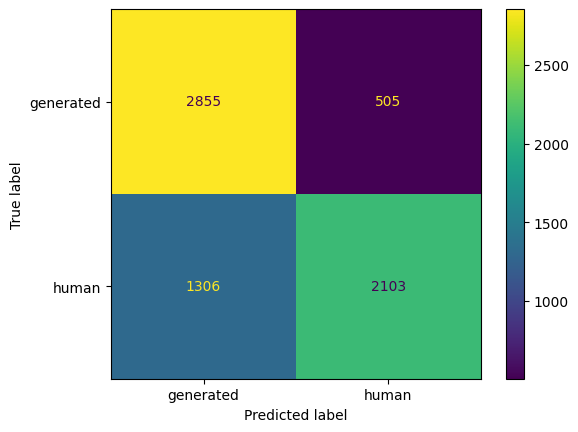

Extra Trees
Best parameters: {'criterion': 'entropy'}
Best CV score: 0.7448293418768097
              precision    recall  f1-score   support

   generated       0.70      0.85      0.77      3360
       human       0.81      0.64      0.72      3409

    accuracy                           0.74      6769
   macro avg       0.76      0.75      0.74      6769
weighted avg       0.76      0.74      0.74      6769



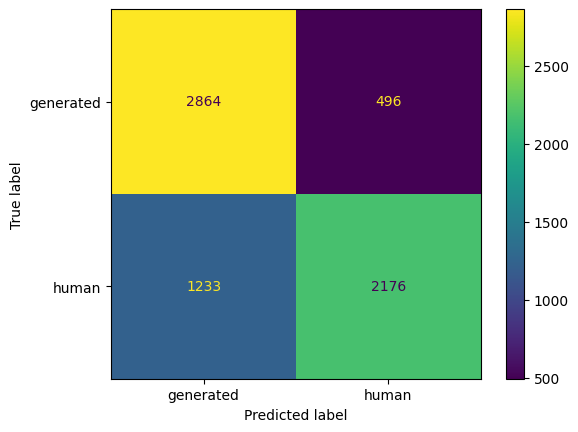

In [12]:
for model in models:
    print(f"{model['name']}")
    print(f"Best parameters: {model['model'].best_params_}")
    print(f"Best CV score: {model['model'].best_score_}")
    y_pred = model['best'].predict(x_test)
    evaluate(y_test, y_pred, labels=labels)

In [68]:
in_dim = x.shape[1]
out_dim = 1

epochs = 100
batch_size = 32

num_workers = 8 # Tune it based on your machine specs
device = init_gpu()

In [77]:
class Network(Classifier):
    def __init__(self, in_dim, out_dim, binary_classifier=False, device=torch.device("cpu"), verbose=True):
        super().__init__(binary_classifier, device, verbose)
        self.l1 = nn.Linear(in_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, out_dim)
        self.dp = nn.Dropout(p=0.6)
        
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.l1(x))
        x = self.dp(x)
        x = self.sig(self.l3(x))
        return x

In [78]:
y_ = LabelBinarizer().fit_transform(y).astype(float)
x_train, x_val, x_test, y_train, y_val, y_test = split(x, y_, test_size=0.1, val_size=0.1)
ds_train = Data(x_train, y_train)
ds_val = Data(x_val, y_val)
ds_test = Data(x_test, y_test)

train_dl = dt.DataLoader(
    ds_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    # pin_memory_device=device.type, # Doesn't work on CPU
)
val_dl = dt.DataLoader(ds_val,     
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    # pin_memory_device=device.type, # Doesn't work on CPU
)
test_dl = dt.DataLoader(ds_test, batch_size=batch_size, shuffle=False)

In [79]:
nn_model = Network(binary_classifier=True, device=device)
loss = nn.BCELoss()
optimizer = opt.Adam(nn_model.parameters(), lr=0.0005)
nn_model.compile(loss, optimizer)

In [80]:
earlystop = EarlyStopping(metric="val_acc", patience=5, baseline=0.7)
history = nn_model.train_loop(train_dl, epochs, data_val=val_dl, callbacks=[earlystop])

Epoch 1 -- loss: 0.0161196 acc: 0.7232974 val_loss: 0.0146954 val_acc: 0.7583457
Epoch 2 -- loss: 0.0117714 acc: 0.8252696 val_loss: 0.0154068 val_acc: 0.7518464
Epoch 3 -- loss: 0.0087744 acc: 0.8807800 val_loss: 0.0173304 val_acc: 0.7438700
Epoch 4 -- loss: 0.0064047 acc: 0.9188949 val_loss: 0.0202137 val_acc: 0.7332349
Epoch 5 -- loss: 0.0045659 acc: 0.9460407 val_loss: 0.0239869 val_acc: 0.7338257
Model restored successfully @ epoch 1


{'acc': tensor(0.7527), 'loss': 0.014987408181313364}
              precision    recall  f1-score   support

         0.0       0.75      0.75      0.75      1680
         1.0       0.75      0.76      0.76      1704

    accuracy                           0.75      3384
   macro avg       0.75      0.75      0.75      3384
weighted avg       0.75      0.75      0.75      3384



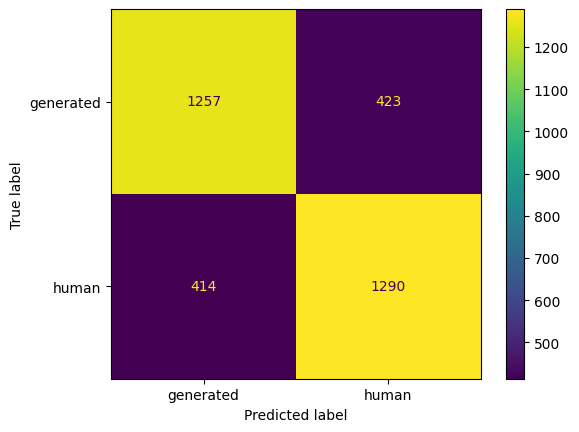

In [84]:
y_pred, metrics = nn_model.test_loop(test_dl)
print(metrics)
evaluate(y_test, y_pred, labels=labels)

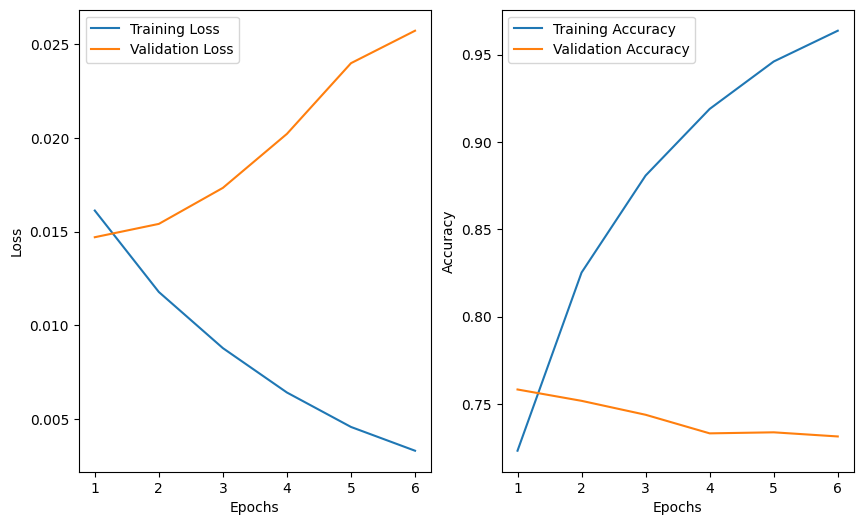

In [86]:
history = nn_model.history
plt_epochs = [h["epoch"] for h in history]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

tl = ax1.plot(plt_epochs, [h["loss"] for h in history], label="Training Loss")
vl = ax1.plot(plt_epochs, [h["val_loss"] for h in history], label="Validation Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ta = ax2.plot(plt_epochs, [h["acc"] for h in history], label="Training Accuracy")
va = ax2.plot(plt_epochs, [h["val_acc"] for h in history], label="Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

plt.show()